# Loading Data

#### In this section, we load data from the pickle files into train, test and valid data

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/traffic-signs-preprocessed/mean_image_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/data5.pickle
/kaggle/input/traffic-signs-preprocessed/data4.pickle
/kaggle/input/traffic-signs-preprocessed/data7.pickle
/kaggle/input/traffic-signs-preprocessed/data8.pickle
/kaggle/input/traffic-signs-preprocessed/data1.pickle
/kaggle/input/traffic-signs-preprocessed/data3.pickle
/kaggle/input/traffic-signs-preprocessed/test.pickle
/kaggle/input/traffic-signs-preprocessed/mean_image_gray.pickle
/kaggle/input/traffic-signs-preprocessed/data6.pickle
/kaggle/input/traffic-signs-preprocessed/data0.pickle
/kaggle/input/traffic-signs-preprocessed/valid.pickle
/kaggle/input/traffic-signs-preprocessed/data2.pickle
/kaggle/input/traffic-signs-preprocessed/labels.pickle
/kaggle/input/traffic-signs-preprocessed/datasets_preparing.py
/kaggle/input/traffic-signs-preprocessed/std_gray.pickle
/kaggle/input/traffic-signs-preprocessed/std_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/label_na

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
import pickle

with open('/kaggle/input/traffic-signs-preprocessed/train.pickle', 'rb') as f:
    train_data = pickle.load(f)
with open('/kaggle/input/traffic-signs-preprocessed/test.pickle', 'rb') as f:
    test_data = pickle.load(f)
with open('/kaggle/input/traffic-signs-preprocessed/valid.pickle', 'rb') as f:
    validation_data = pickle.load(f)

In [4]:
train_data['features'].shape

(34799, 32, 32, 3)

In [5]:
test_data['features'].shape

(12630, 32, 32, 3)

In [6]:
validation_data['features'].shape

(4410, 32, 32, 3)

In [7]:
X_train = train_data['features']
X_test = test_data['features']
X_valid = validation_data['features']

y_train = train_data['labels']
y_test = test_data['labels']
y_valid = validation_data['labels']

In [8]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0

In [9]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

# EDA

#### Here, we will perform some basic EDA on the images, like class imbalance, average image for each class, bounding box analysis and image size analysis.

In [10]:
num_classes = len(np.unique(y_train))
print(f"Number of traffic sign classes: {num_classes}")

Number of traffic sign classes: 43


In [11]:
# Load the label_id -> label_name mapping

labels = pd.read_csv('/kaggle/input/traffic-signs-preprocessed/label_names.csv')
label_dict = labels['SignName'].to_dict()

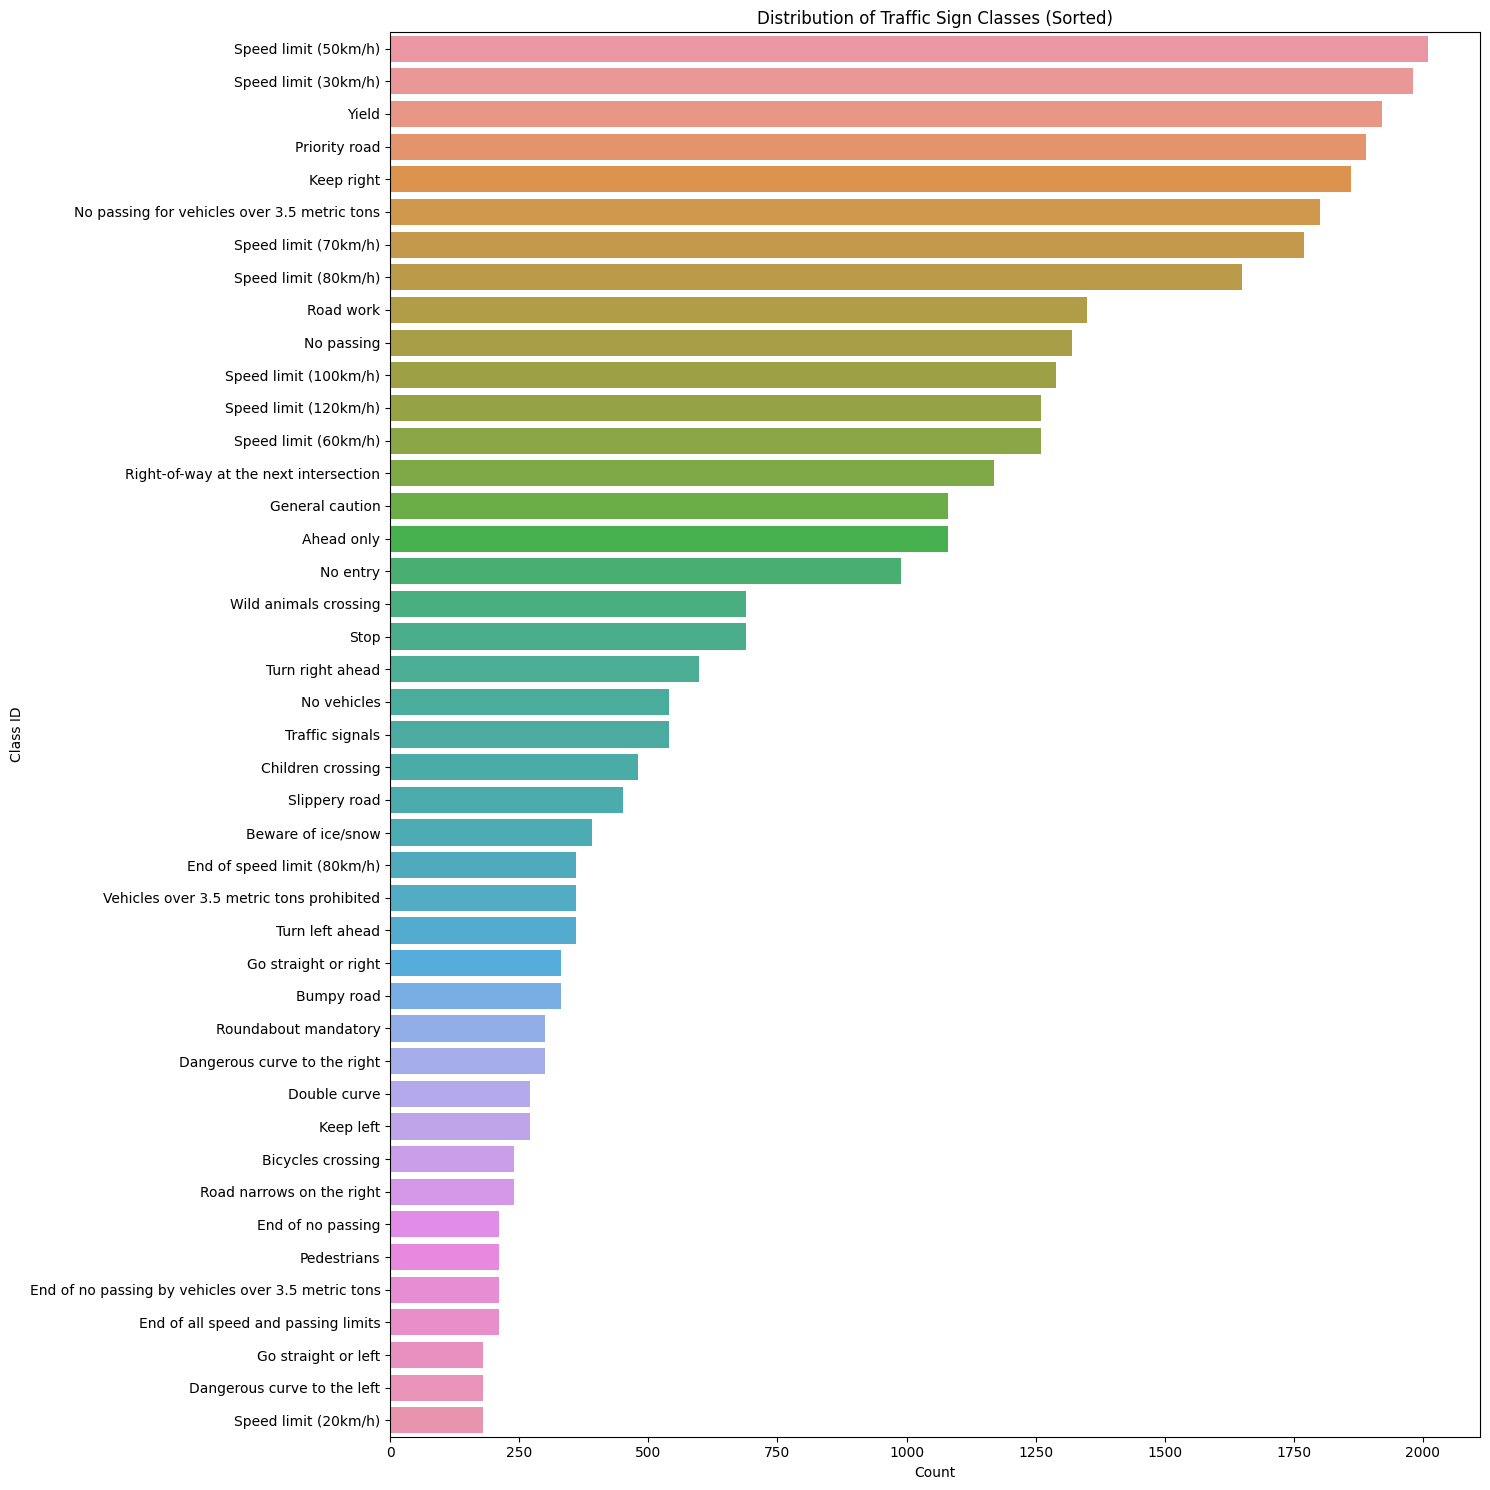

In [12]:
y_train_series = pd.Series(y_train)

class_counts = y_train_series.value_counts().sort_values(ascending=False)

sorted_class_ids = class_counts.index.tolist()

plt.figure(figsize=(15, 15))
sns.countplot(y=y_train_series, order=sorted_class_ids)
plt.title("Distribution of Traffic Sign Classes (Sorted)")
plt.ylabel("Class ID")
plt.xlabel("Count")
plt.yticks(
    ticks=np.arange(len(sorted_class_ids)), 
    labels=labels.set_index('ClassId').loc[sorted_class_ids]['SignName'].tolist()
)
plt.tight_layout()
plt.show()


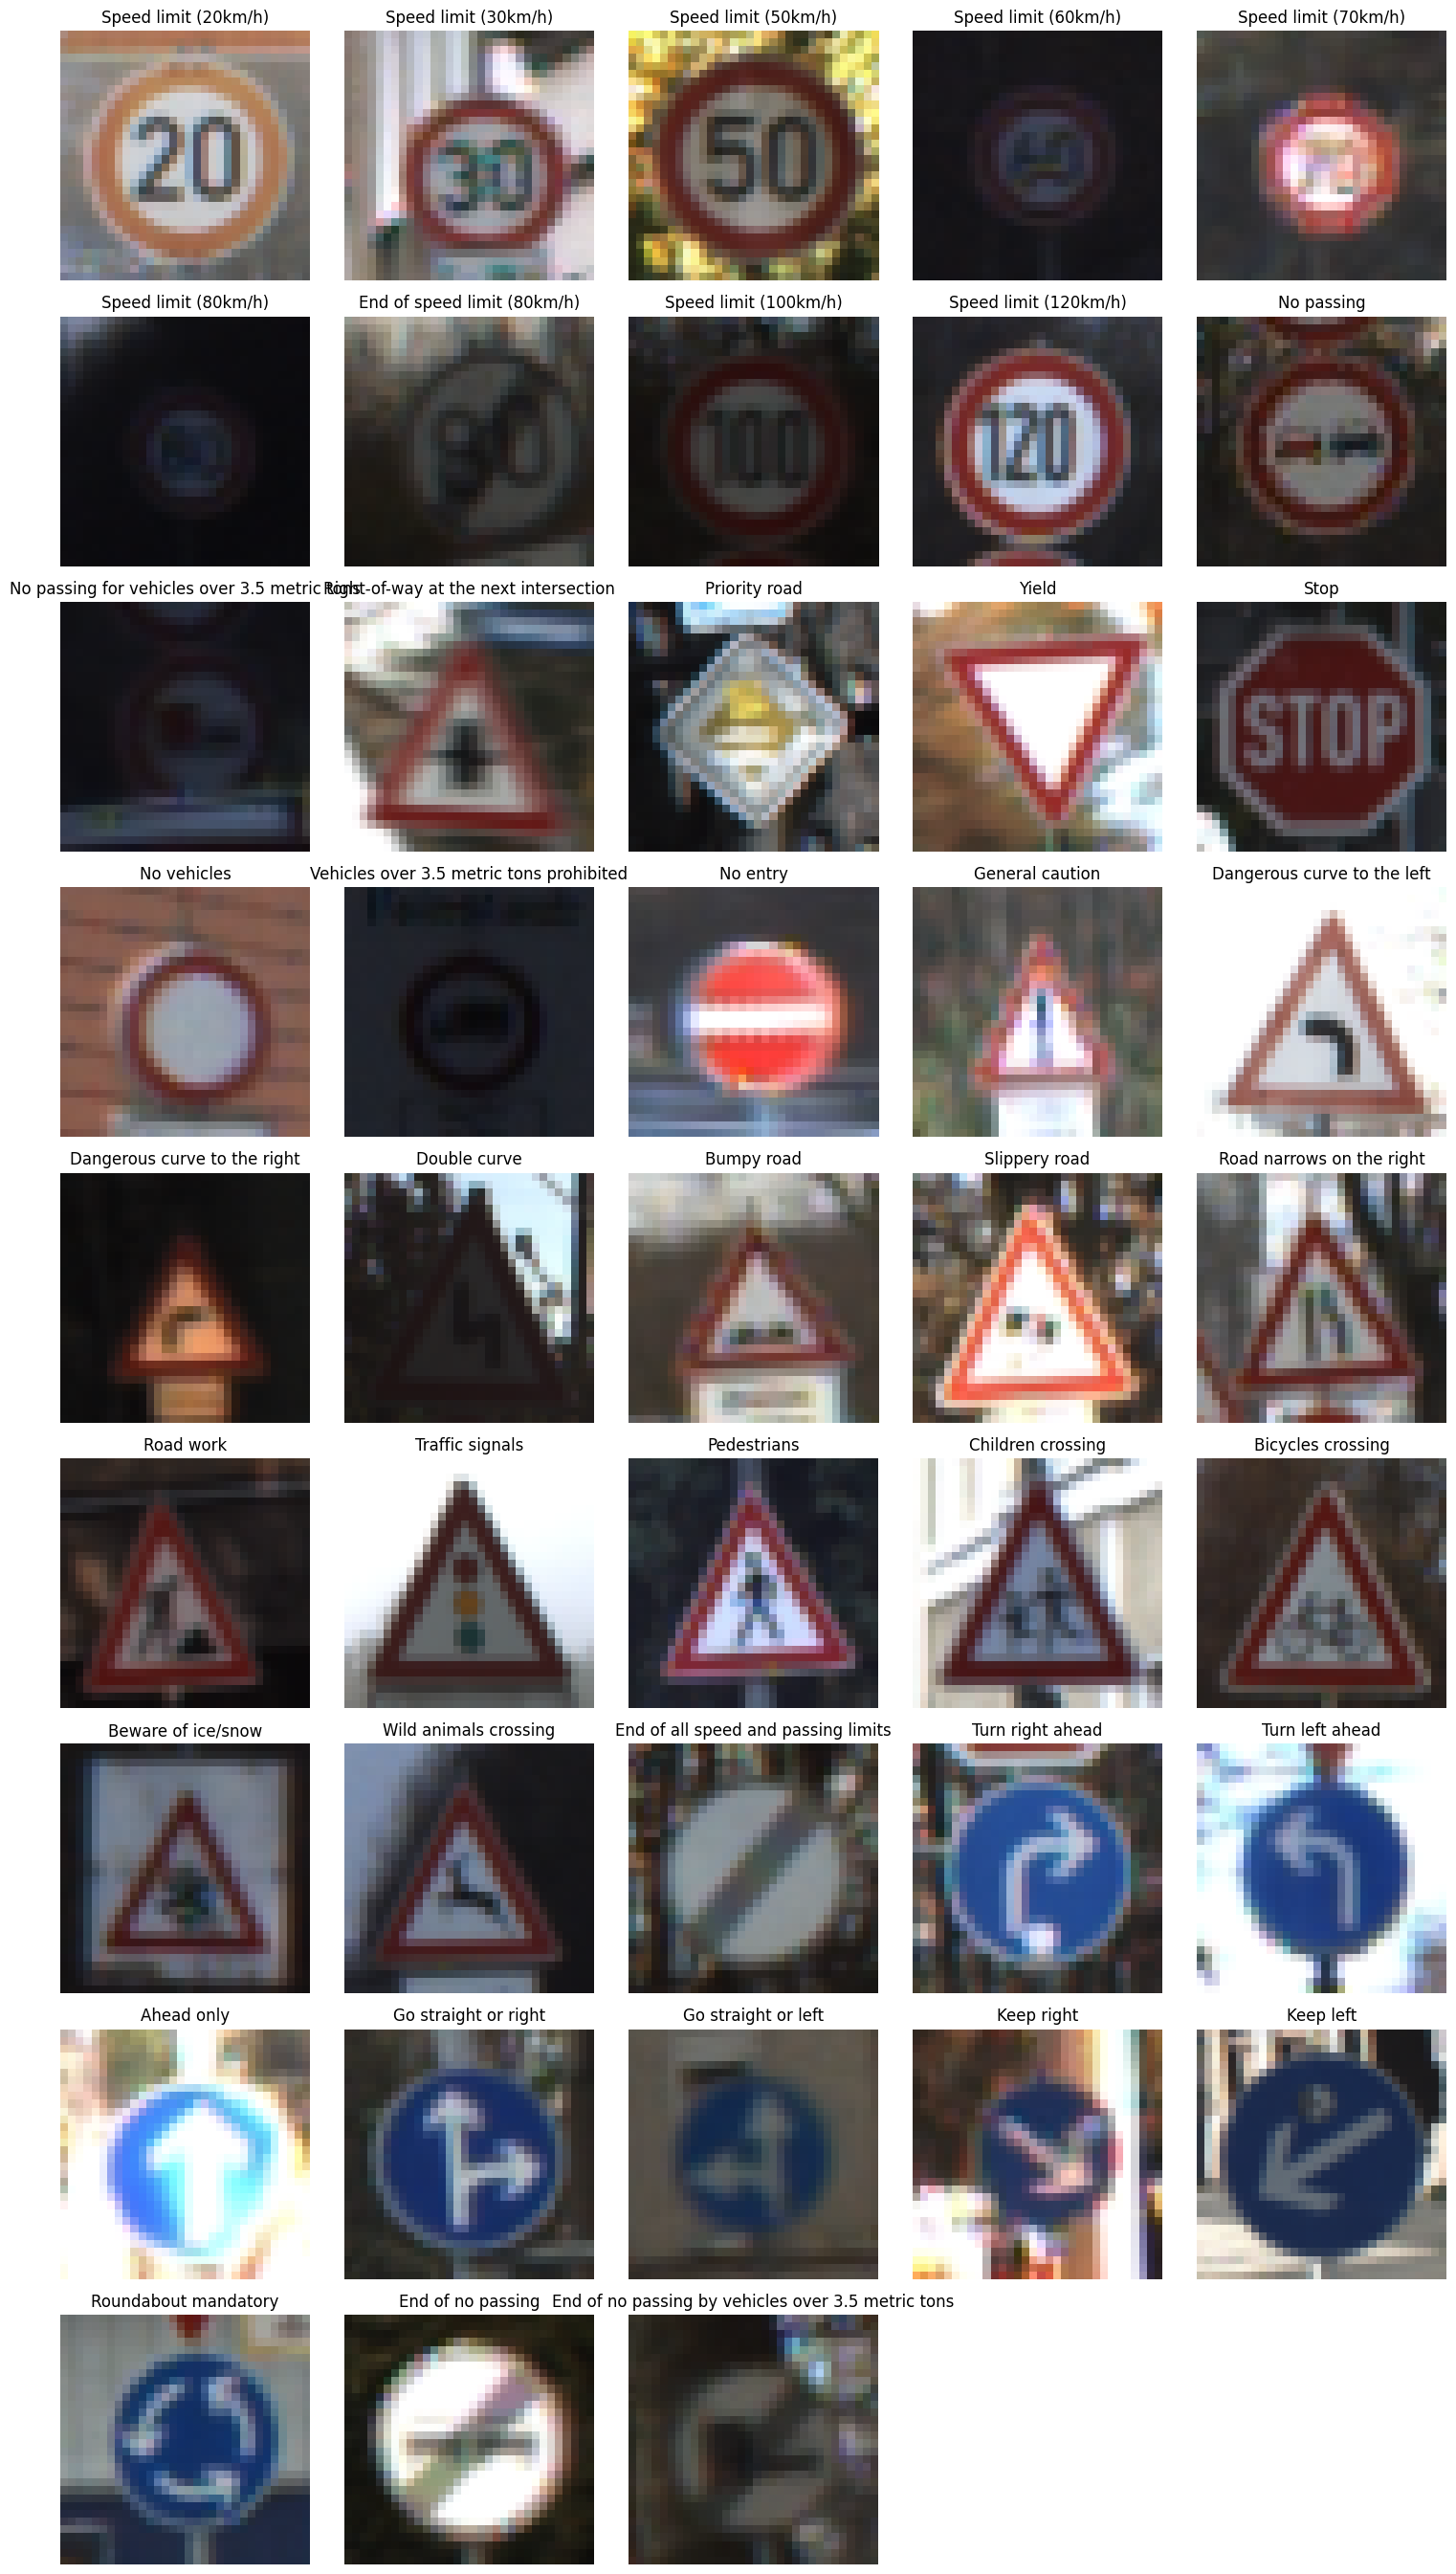

In [13]:
# Displaying a sample image from each of the 43 classes

class_ids = np.unique(train_data['labels'])
num_classes = len(class_ids)
cols = 5
rows = (num_classes + cols - 1) // cols

plt.figure(figsize=(cols * 3, rows * 3))

for idx, class_id in enumerate(class_ids):  
    imgs = train_data['features'][train_data['labels'] == class_id]
    img = random.choice(imgs)
    
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(label_dict[class_id])
    plt.axis('off')

plt.tight_layout()
plt.show()

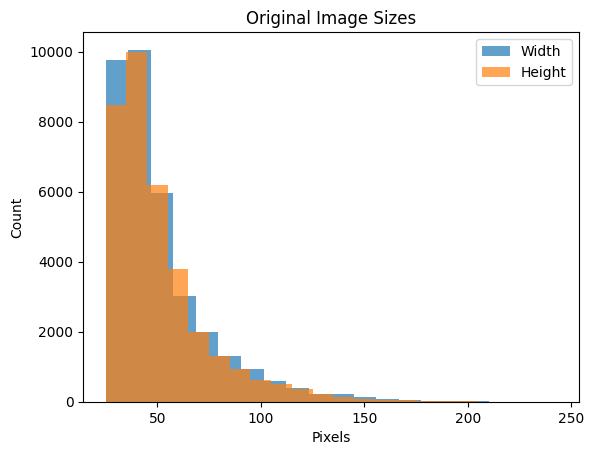

In [14]:
# Distribution of image size (width, height)

sizes = train_data['sizes']
widths, heights = sizes[:, 0], sizes[:, 1]

plt.hist(widths, bins=20, alpha=0.7, label='Width')
plt.hist(heights, bins=20, alpha=0.7, label='Height')
plt.title("Original Image Sizes")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.show()

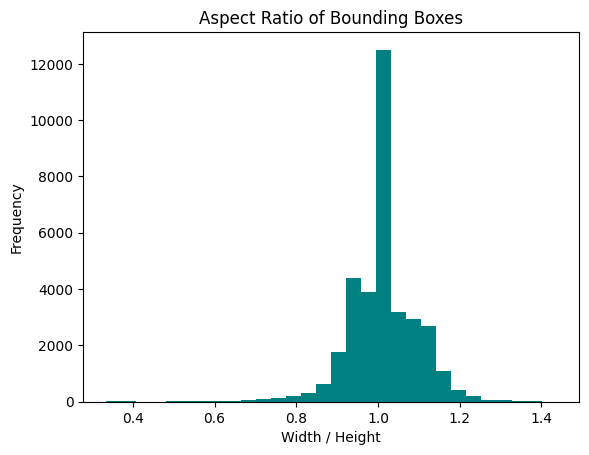

In [15]:
# Distribution of Bounding box aspect ratio

coords = train_data['coords']
box_widths = coords[:, 2] - coords[:, 0]
box_heights = coords[:, 3] - coords[:, 1]
aspect_ratios = box_widths / box_heights

plt.hist(aspect_ratios, bins=30, color='teal')
plt.title("Aspect Ratio of Bounding Boxes")
plt.xlabel("Width / Height")
plt.ylabel("Frequency")
plt.show()

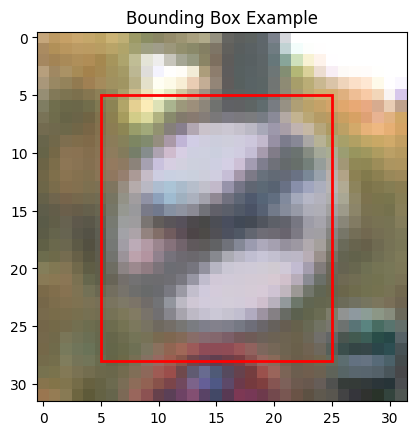

In [16]:
# Sample bounding box

img = train_data['features'][100]
x1, y1, x2, y2 = train_data['coords'][100]

plt.imshow(img)
plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=2))
plt.title("Bounding Box Example")
plt.show()

In [ ]:
# Displaying the average image for each class that our CNN model will learn

mean_images = {}
for class_id in np.unique(y_train):
    imgs = X_train[y_train == class_id]
    mean_img = np.mean(imgs, axis=0)
    mean_images[class_id] = mean_img

# Setup grid dimensions
num_classes = len(mean_images)
cols = 4
rows = (num_classes + cols - 1) // cols  # Ceiling division

# Plot
plt.figure(figsize=(cols * 3, rows * 3))
for i, (cls, img) in enumerate(mean_images.items()):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"{cls} - {label_dict[cls]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Training and Evaluation

#### Now, we will train 3 models:
1. Small (3 Conv layers, ~165k params)
2. Medium (5 Conv Layers, ~2.6M params)
3. Large (9 Conv Layers, ~8.1M params)

In [18]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)
y_valid = to_categorical(y_valid, num_classes=43)

2025-05-14 13:42:37.812332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747230158.005756      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747230158.061363      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input

model1 = Sequential()

model1.add(Input(shape=(32,32,3)))

model1.add(Conv2D(32, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(128, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(43, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

I0000 00:00:1747230170.958717      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history1 = model1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1747230175.881934     118 service.cc:148] XLA service 0x7cfd70027410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747230175.882502     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747230176.181913     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


 39/272 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0555 - loss: 3.6504

I0000 00:00:1747230178.470722     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.1995 - loss: 2.9957 - val_accuracy: 0.6746 - val_loss: 1.1749 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7286 - loss: 0.8711 - val_accuracy: 0.8685 - val_loss: 0.4907 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9024 - loss: 0.3406 - val_accuracy: 0.8932 - val_loss: 0.4114 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9468 - loss: 0.1893 - val_accuracy: 0.9200 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9655 - loss: 0.1230 - val_accuracy: 0.9211 - val_loss: 0.3533 - learning_rate: 0.0010
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9727 - loss: 0.0963 - val_accuracy: 0.9367 - val_loss: 0.3082 - learning_rate: 0.0010
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9783 - loss: 0.0759 - val_accura

In [22]:
loss, acc = model1.evaluate(X_test, y_test, verbose=0)
print(f"Small CNN - Test Accuracy: {acc:.4f}")

Small CNN - Test Accuracy: 0.9572


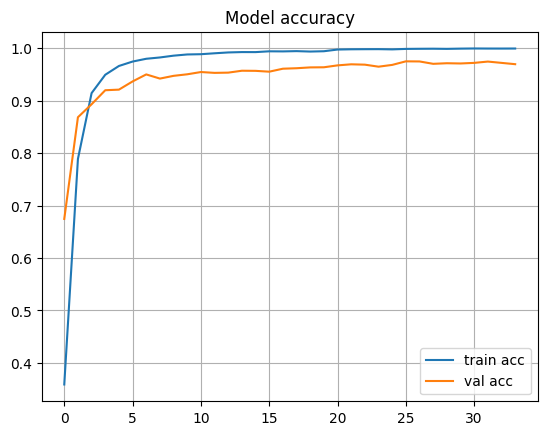

In [23]:
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.title('Model accuracy')
plt.legend()
plt.grid()
plt.show()

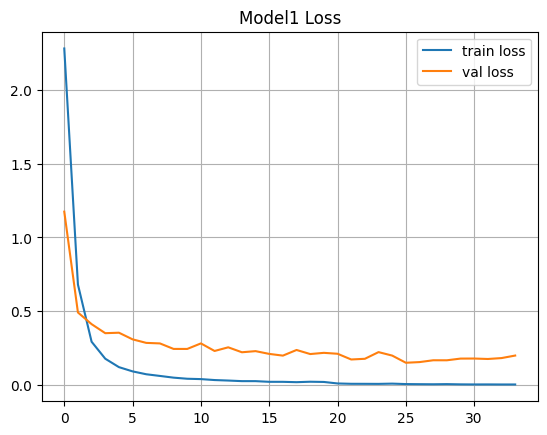

In [24]:
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.title('Model1 Loss')
plt.legend()
plt.grid()
plt.show()

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


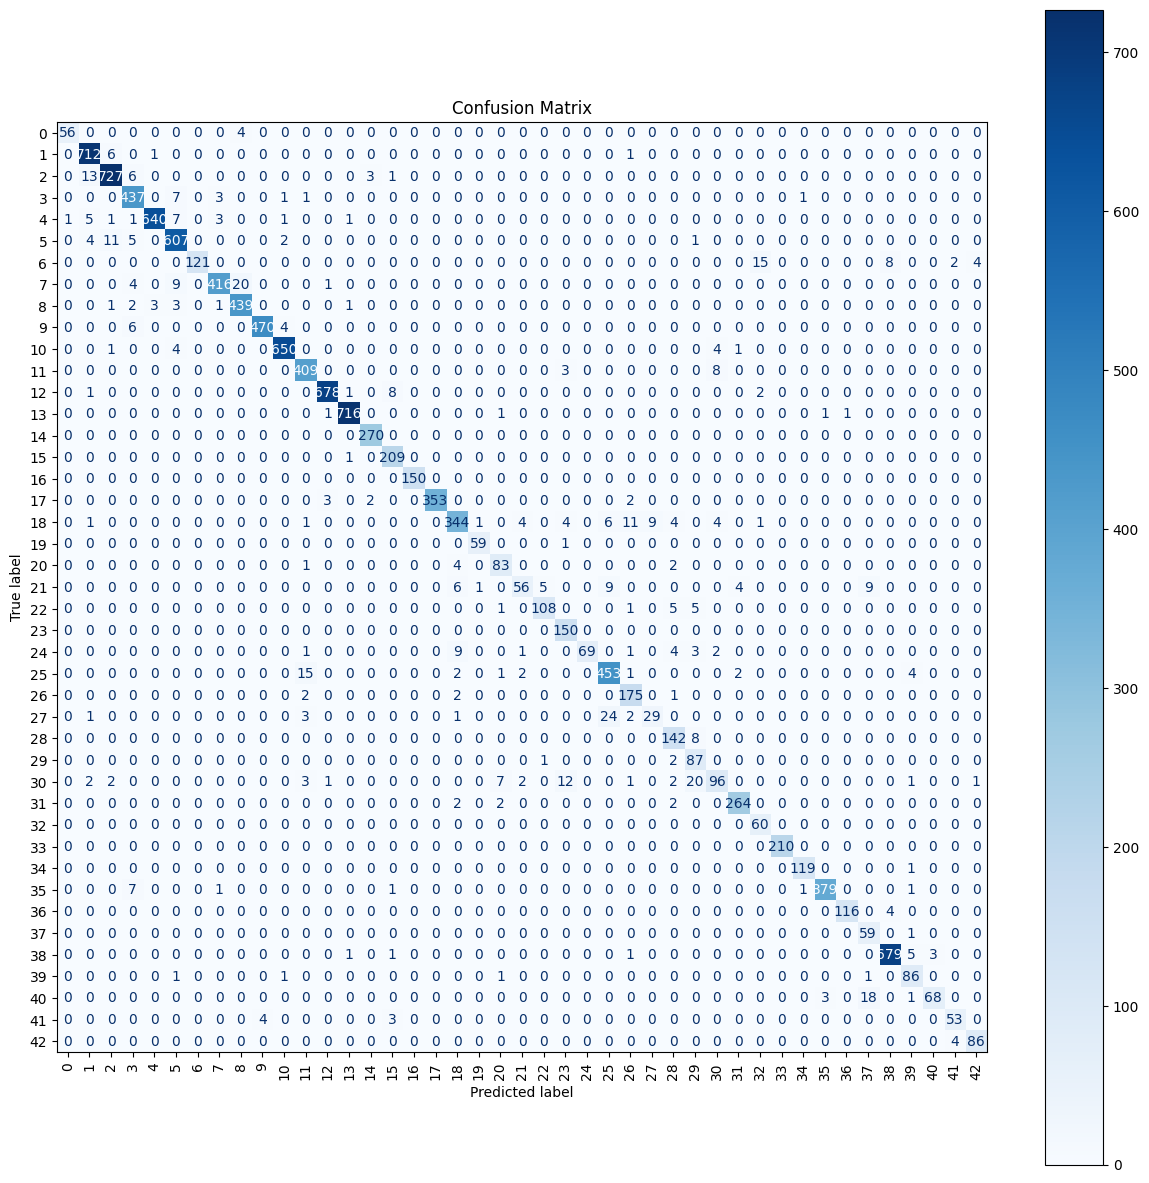

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model1.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_class)

# Create a figure with desired size BEFORE plotting
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=90, ax=ax)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_class, target_names=[label_dict[i] for i in sorted(label_dict)]))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.98      0.93      0.96        60
                              Speed limit (30km/h)       0.96      0.99      0.98       720
                              Speed limit (50km/h)       0.97      0.97      0.97       750
                              Speed limit (60km/h)       0.93      0.97      0.95       450
                              Speed limit (70km/h)       0.99      0.97      0.98       660
                              Speed limit (80km/h)       0.95      0.96      0.96       630
                       End of speed limit (80km/h)       1.00      0.81      0.89       150
                             Speed limit (100km/h)       0.98      0.92      0.95       450
                             Speed limit (120km/h)       0.95      0.98      0.96       450
                                        No passing       0.99      0.98      0.

In [ ]:
model2 = Sequential()

model2.add(Input(shape=(32, 32, 3)))

# Block 1
model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model2.add(Conv2D(256, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(43, activation='softmax'))  # 43 traffic sign classes

# Compile
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │              

 Total params: 2,677,611 (10.21 MB)

 Trainable params: 2,676,331 (10.21 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
history2 = model2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.2273 - loss: 3.1893 - val_accuracy: 0.2542 - val_loss: 2.6334 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8813 - loss: 0.3686 - val_accuracy: 0.9707 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9773 - loss: 0.0797 - val_accuracy: 0.9776 - val_loss: 0.0872 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9865 - loss: 0.0462 - val_accuracy: 0.9834 - val_loss: 0.0631 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9901 - loss: 0.0328 - val_accuracy: 0.9819 - val_loss: 0.0535 - learning_rate: 0.0010
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9930 - loss: 0.0244 - val_accuracy: 0.9846 - val_loss: 0.0595 - learning_rate: 0.0010
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9932 - loss: 0

In [ ]:
loss, acc = model2.evaluate(X_test, y_test, verbose=0)
print(f"Medium CNN - Test Accuracy: {acc:.4f}")

Medium CNN - Test Accuracy: 0.9819


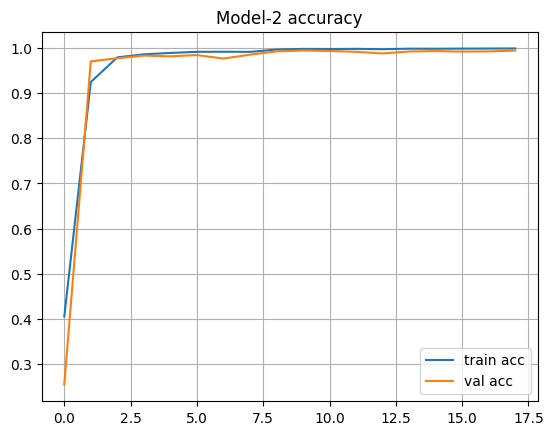

In [ ]:
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.title('Model-2 accuracy')
plt.legend()
plt.grid()
plt.show()

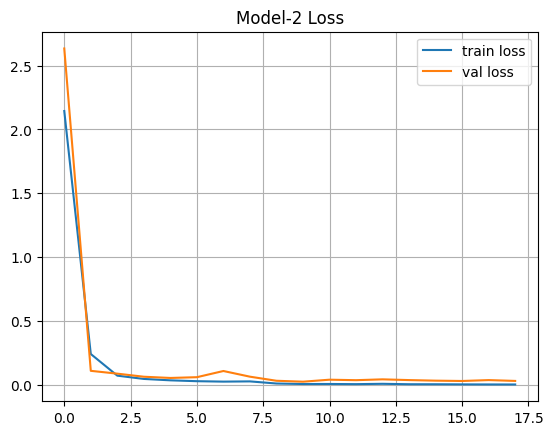

In [ ]:
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.title('Model-2 Loss')
plt.legend()
plt.grid()
plt.show()

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


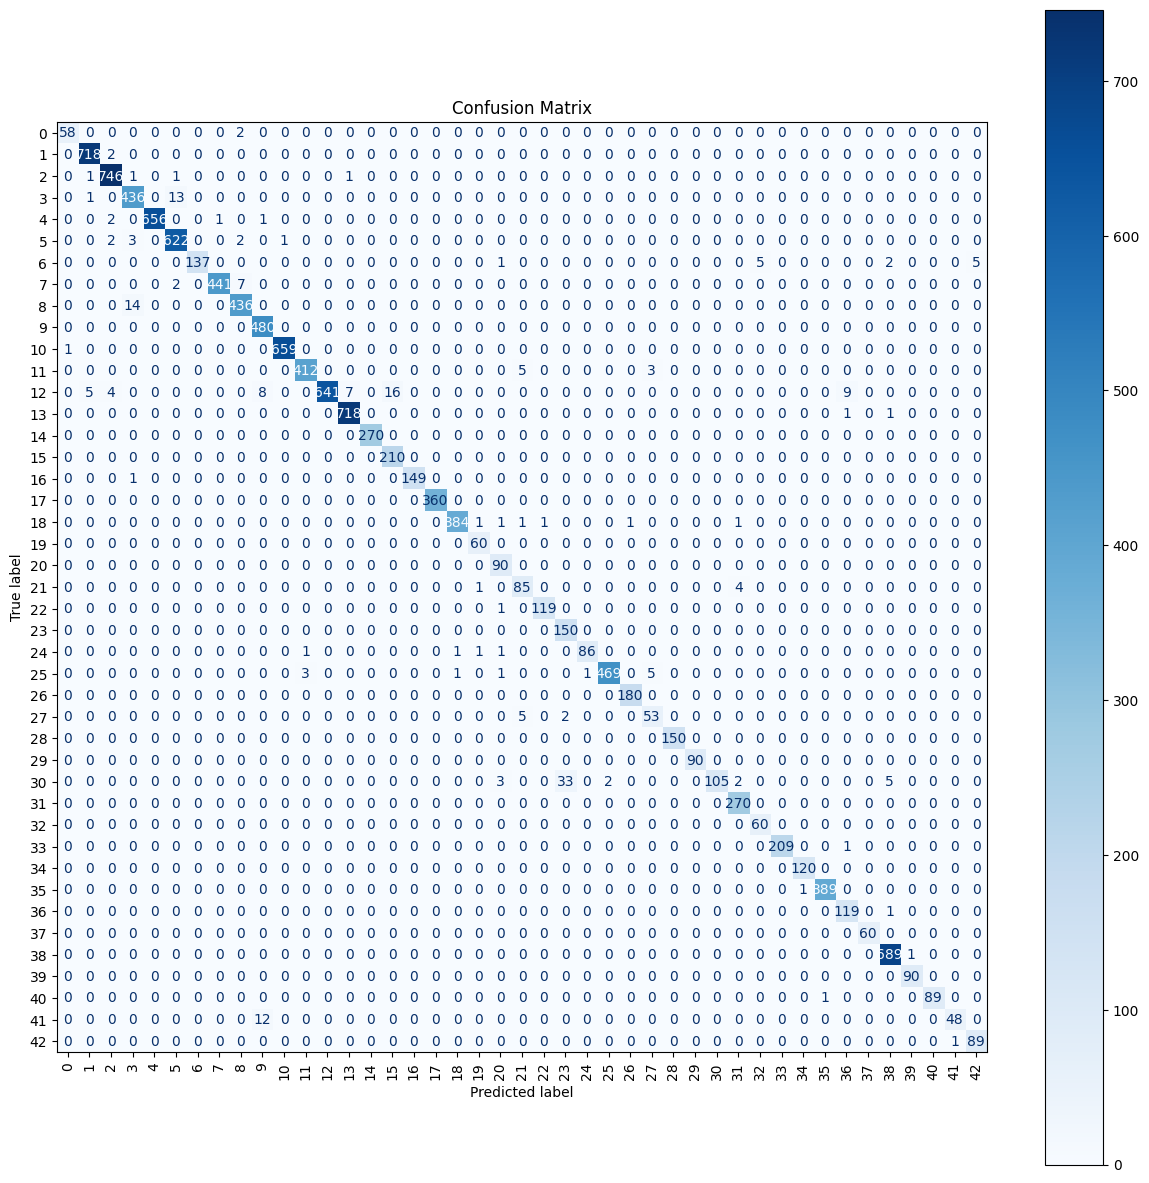

In [ ]:
y_pred = model2.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_class)

# Create a figure with desired size BEFORE plotting
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=90, ax=ax)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_class, target_names=[label_dict[i] for i in sorted(label_dict)]))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.98      0.97      0.97        60
                              Speed limit (30km/h)       0.99      1.00      0.99       720
                              Speed limit (50km/h)       0.99      0.99      0.99       750
                              Speed limit (60km/h)       0.96      0.97      0.96       450
                              Speed limit (70km/h)       1.00      0.99      1.00       660
                              Speed limit (80km/h)       0.97      0.99      0.98       630
                       End of speed limit (80km/h)       1.00      0.91      0.95       150
                             Speed limit (100km/h)       1.00      0.98      0.99       450
                             Speed limit (120km/h)       0.98      0.97      0.97       450
                                        No passing       0.96      1.00      0.

In [ ]:
model3 = Sequential()

model3.add(Input(shape=(32, 32, 3)))

# Block 1
model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model3.add(Conv2D(128, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model3.add(Conv2D(256, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(256, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model3.add(Conv2D(512, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(512, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(512, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(43, activation='softmax'))  # 43 traffic sign classes

# Compile
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 256)           │           1,0

 Total params: 8,175,211 (31.19 MB)

 Trainable params: 8,170,347 (31.17 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [ ]:
callbacks = [
    ReduceLROnPlateau(patience=4, factor=0.5)
]

history3 = model3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.0656 - loss: 3.6615 - val_accuracy: 0.0991 - val_loss: 3.6295 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.3466 - loss: 2.0237 - val_accuracy: 0.4855 - val_loss: 1.5401 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.5649 - loss: 1.2144 - val_accuracy: 0.6907 - val_loss: 0.9241 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7348 - loss: 0.7143 - val_accuracy: 0.8637 - val_loss: 0.4974 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8447 - loss: 0.4397 - val_accuracy: 0.9070 - val_loss: 0.3388 - learning_rate: 0.0010
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8928 - loss: 0.3039 - val_accuracy: 0.9458 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9292 - loss: 0

In [ ]:
loss, acc = model3.evaluate(X_test, y_test, verbose=0)
print(f"Large CNN - Test Accuracy: {acc:.4f}")

Large CNN - Test Accuracy: 0.9808


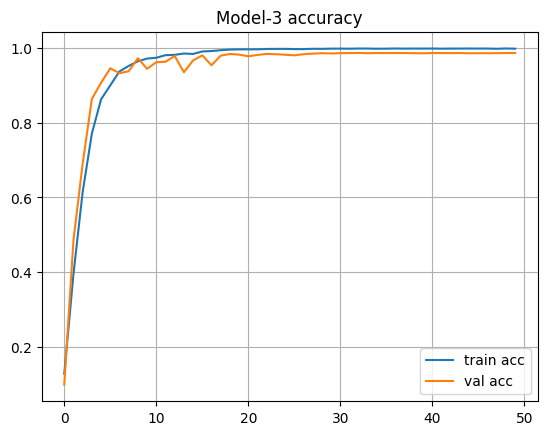

In [ ]:
plt.plot(history3.history['accuracy'], label='train acc')
plt.plot(history3.history['val_accuracy'], label='val acc')
plt.title('Model-3 accuracy')
plt.legend()
plt.grid()
plt.show()

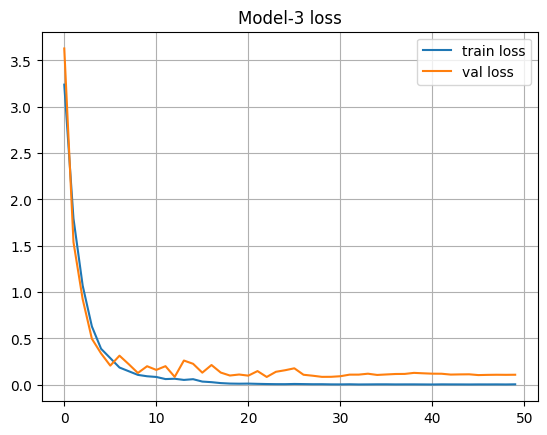

In [ ]:
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.title('Model-3 loss')
plt.legend()
plt.grid()
plt.show()

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


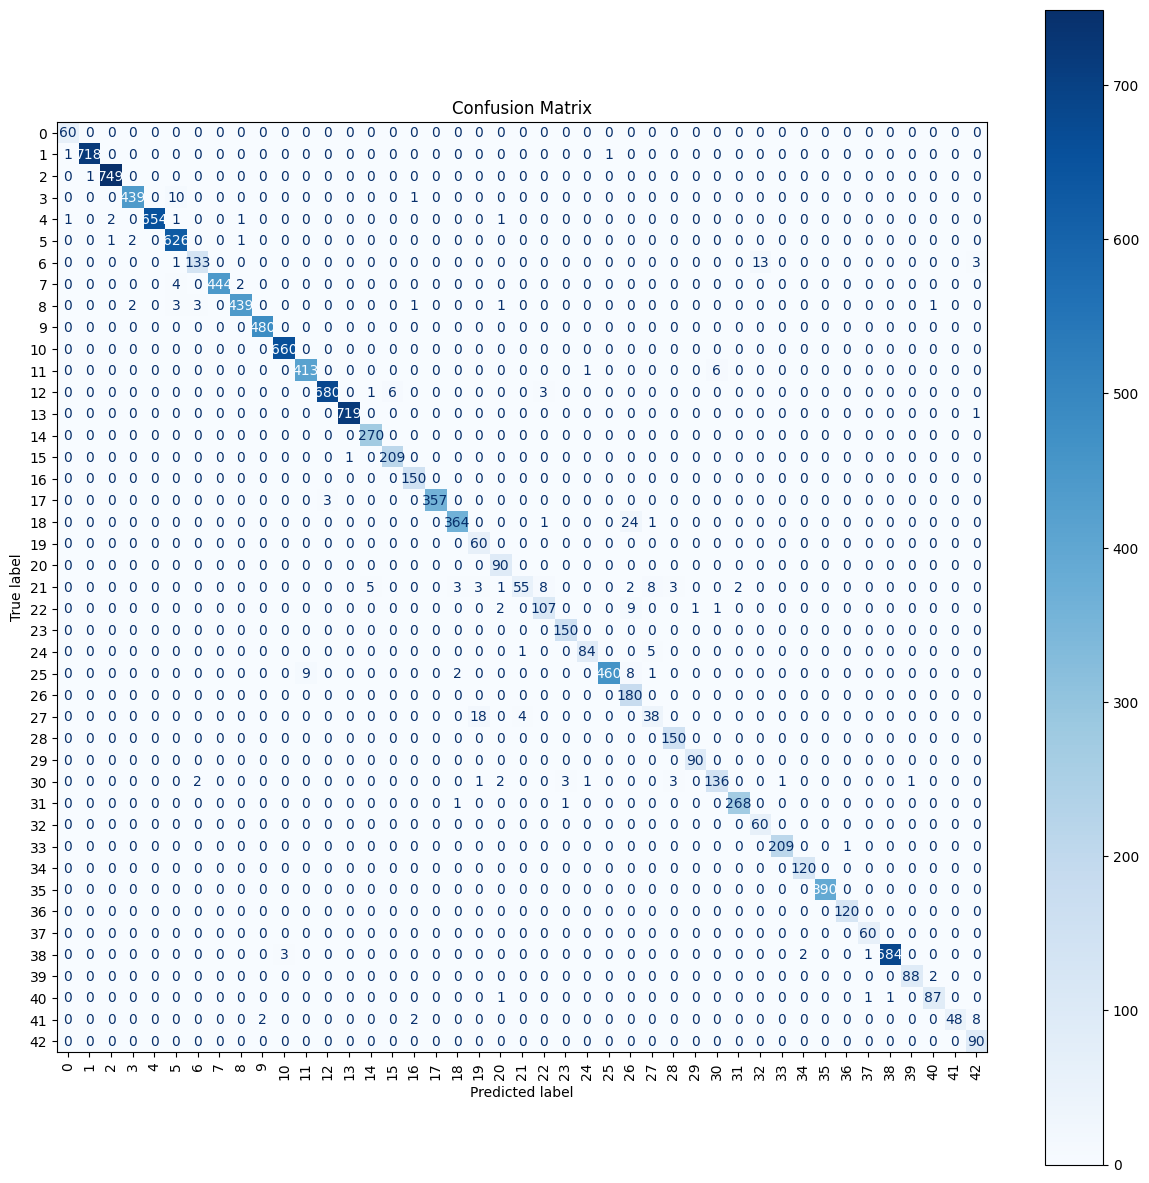

In [ ]:
y_pred = model3.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_class)

# Create a figure with desired size BEFORE plotting
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=90, ax=ax)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_class, target_names=[label_dict[i] for i in sorted(label_dict)]))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.97      1.00      0.98        60
                              Speed limit (30km/h)       1.00      1.00      1.00       720
                              Speed limit (50km/h)       1.00      1.00      1.00       750
                              Speed limit (60km/h)       0.99      0.98      0.98       450
                              Speed limit (70km/h)       1.00      0.99      1.00       660
                              Speed limit (80km/h)       0.97      0.99      0.98       630
                       End of speed limit (80km/h)       0.96      0.89      0.92       150
                             Speed limit (100km/h)       1.00      0.99      0.99       450
                             Speed limit (120km/h)       0.99      0.98      0.98       450
                                        No passing       1.00      1.00      1.

In [ ]:
model1.save('traffic-sign-cnn-small.keras')
model2.save('traffic-sign-cnn-medium.keras')
model3.save('traffic-sign-cnn-large.keras')

# Fine-Tuning MobileNetV2

#### In this section, we fine-tune the MobileNetV2 model on our dataset as a benchmark for our trained models.

In [56]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [45]:
IMG_SIZE = 96  # MobileNetV2 can handle 96x96 well
X_train_resized = tf.image.resize(X_train, (IMG_SIZE, IMG_SIZE))
X_valid_resized = tf.image.resize(X_valid, (IMG_SIZE, IMG_SIZE))
X_test_resized  = tf.image.resize(X_test,  (IMG_SIZE, IMG_SIZE))

In [63]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

In [64]:
base_model.trainable = True
fine_tune_at = 100  # Freeze first 100 layers, tune the rest

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(43, activation='softmax')(x)

model_ft = Model(inputs, outputs)

model_ft.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
model_ft.summary()

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 43)                  │          55,083 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,313,067 (8.82 MB)

 Trainable params: 1,916,523 (7.31 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [65]:
history4 = model_ft.fit(X_train_resized, y_train,
                       validation_data=(X_valid_resized, y_valid),
                       epochs=25,
                       batch_size=64,
                       callbacks=[
                           EarlyStopping(patience=5, restore_best_weights=True),
                           ReduceLROnPlateau(patience=3, factor=0.5)
                       ])

Epoch 1/25


E0000 00:00:1747231347.888990     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747231348.075667     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747231348.352702     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747231348.566592     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


541/544 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7575 - loss: 0.8846

E0000 00:00:1747231366.725085     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747231366.910654     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747231367.186219     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747231367.396041     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


544/544 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.7584 - loss: 0.8813 - val_accuracy: 0.5628 - val_loss: 3.3895 - learning_rate: 0.0010
Epoch 2/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9628 - loss: 0.1171 - val_accuracy: 0.6744 - val_loss: 2.8313 - learning_rate: 0.0010
Epoch 3/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9760 - loss: 0.0793 - val_accuracy: 0.7526 - val_loss: 1.9535 - learning_rate: 0.0010
Epoch 4/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9812 - loss: 0.0616 - val_accuracy: 0.8104 - val_loss: 1.3917 - learning_rate: 0.0010
Epoch 5/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9871 - loss: 0.0419 - val_accuracy: 0.7878 - val_loss: 1.7754 - learning_rate: 0.0010
Epoch 6/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9859 - loss: 0.0502 - val_accuracy: 0.8510 - val_loss: 1.1300 - learning_rate: 0.0010
Epoch 7/25
544/544 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9897 - loss: 0.0346

In [68]:
loss, acc = model_ft.evaluate(X_test_resized, y_test, verbose=0)
print(f"MobileNetV2 - Test Accuracy: {acc:.4f}")

MobileNetV2 - Test Accuracy: 0.9451


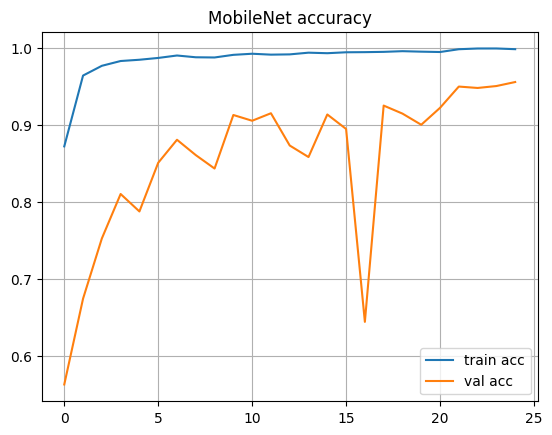

In [70]:
plt.plot(history4.history['accuracy'], label='train acc')
plt.plot(history4.history['val_accuracy'], label='val acc')
plt.title('MobileNet accuracy')
plt.legend()
plt.grid()
plt.show()

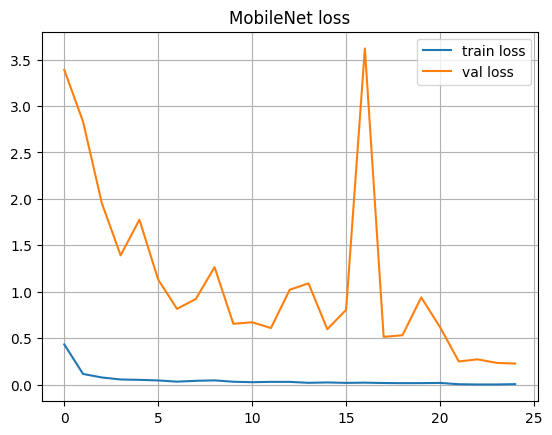

In [71]:
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.title('MobileNet loss')
plt.legend()
plt.grid()
plt.show()

395/395 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step


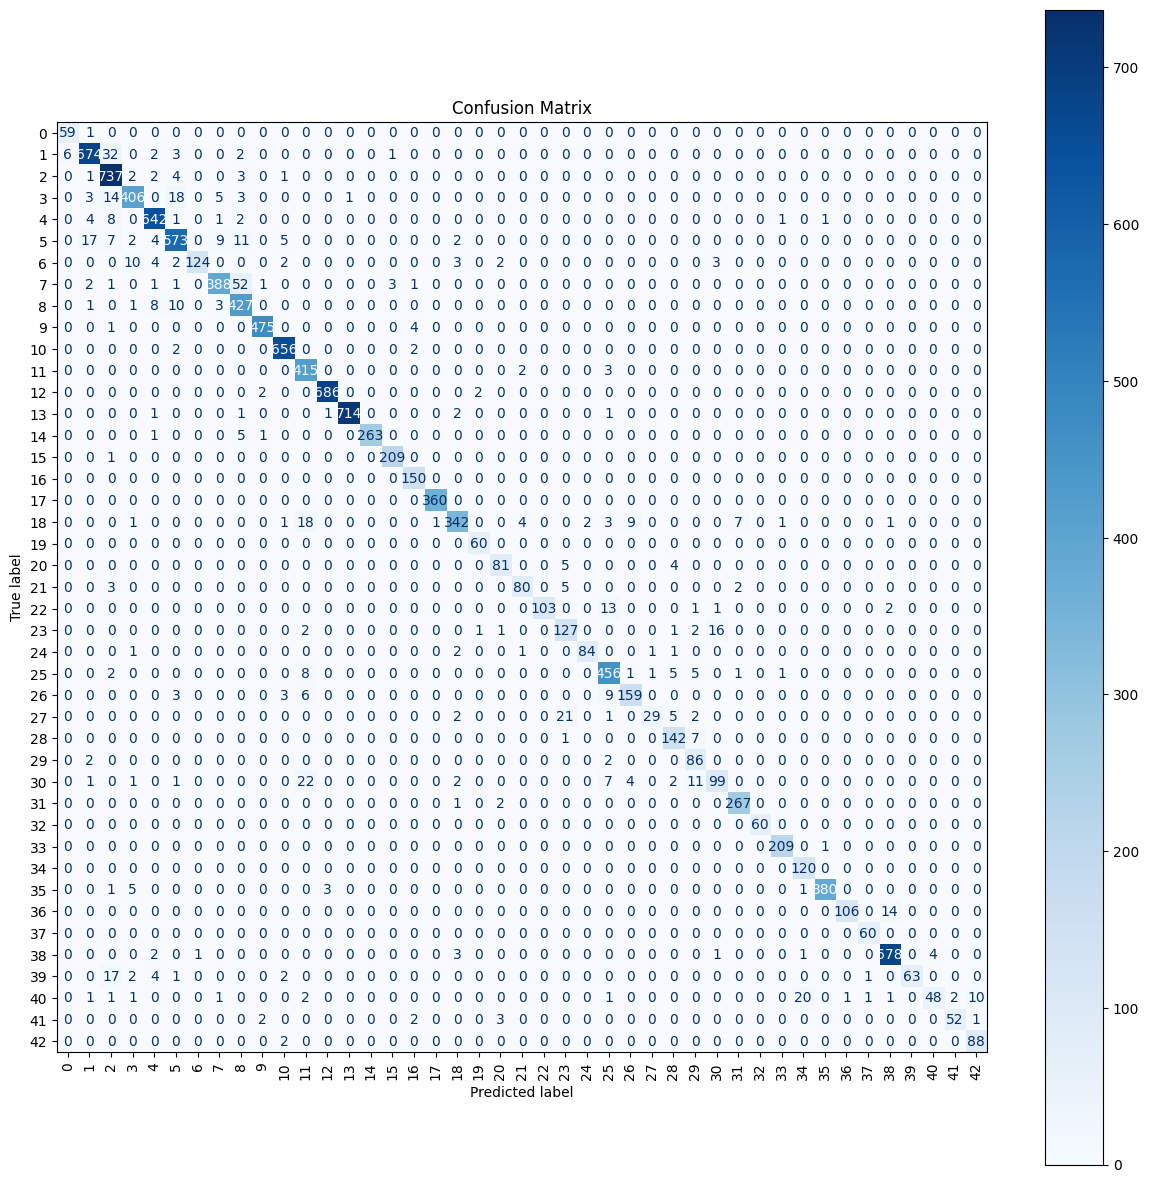

In [72]:
y_pred = model_ft.predict(X_test_resized)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_class)

# Create a figure with desired size BEFORE plotting
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=90, ax=ax)
plt.title("Confusion Matrix")
plt.show()

In [73]:
print(classification_report(y_true, y_pred_class, target_names=[label_dict[i] for i in sorted(label_dict)]))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.91      0.98      0.94        60
                              Speed limit (30km/h)       0.95      0.94      0.94       720
                              Speed limit (50km/h)       0.89      0.98      0.94       750
                              Speed limit (60km/h)       0.94      0.90      0.92       450
                              Speed limit (70km/h)       0.96      0.97      0.96       660
                              Speed limit (80km/h)       0.93      0.91      0.92       630
                       End of speed limit (80km/h)       0.99      0.83      0.90       150
                             Speed limit (100km/h)       0.95      0.86      0.91       450
                             Speed limit (120km/h)       0.84      0.95      0.89       450
                                        No passing       0.99      0.99      0.

# Models Comparison

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


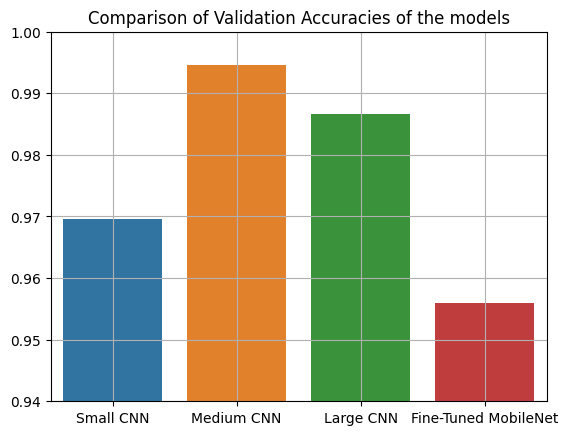

In [81]:
val_accuracies = [history1.history['val_accuracy'][-1],
                  history2.history['val_accuracy'][-1],
                  history3.history['val_accuracy'][-1],
                  history4.history['val_accuracy'][-1]]

sns.barplot(x=['Small CNN', 'Medium CNN', 'Large CNN', 'Fine-Tuned MobileNet'], 
           y=val_accuracies)
plt.grid()
plt.ylim(0.94,1.0)
plt.title("Comparison of Validation Accuracies")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


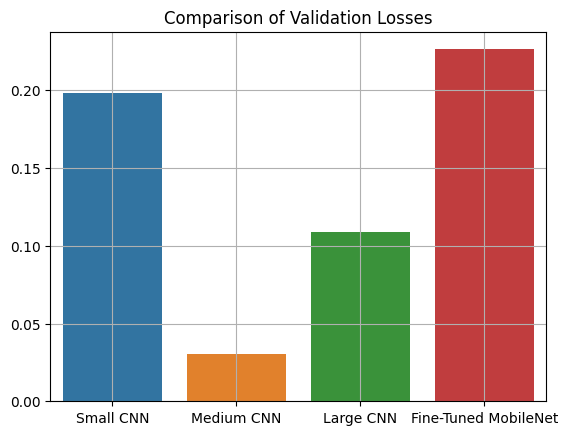

In [82]:
val_losses = [history1.history['val_loss'][-1],
                  history2.history['val_loss'][-1],
                  history3.history['val_loss'][-1],
                  history4.history['val_loss'][-1]]

sns.barplot(x=['Small CNN', 'Medium CNN', 'Large CNN', 'Fine-Tuned MobileNet'], 
           y=val_losses)
plt.grid()
# plt.ylim(0.94,1.0)
plt.title("Comparison of Validation Losses")
plt.show()